In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

ImportError: numpy.core.multiarray failed to import

In [2]:
path_to_df = "/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/notebooks/deprecated/model_evals.csv"
df = pd.read_csv(path_to_df)

In [3]:
metrics = {
    'auc':{'label':'AUROC','lim':[-0.15,0.05]},
    'auprc':{'label':'AUPRC_C','lim':[-0.3,0.3]},
    'ace_abs_logistic_logit':{'label':'ACE','lim':[-0.02,0.1]},
}

In [4]:
task_colours = {    
    # mortality / ADT
    'sepsis':'olive', # different than the rest 
    'hospital_mortality':'black', #dark grey    
    'LOS_7':'grey', # another grey    
    'readmission_30':'lightgrey', #light gray       
    # Chemistry    
    'aki_lab_aki3_label':'steelblue',
    'hyperkalemia_lab_severe_label':'dodgerblue',    
    'hypoglycemia_lab_severe_label':'darkturquoise',    
    'hyponatremia_lab_severe_label':'deepskyblue', 
    # Cytopenia
    'neutropenia_lab_severe_label':'orangered',
    'anemia_lab_severe_label':'salmon',      
    'thrombocytopenia_lab_severe_label':'tomato', 
}

titles = {
    'hospital_mortality':'In-hospital Mortality', 
    'sepsis':'SEPSIS-3', 
    'LOS_7':'Length of Stay > 7 days', 
    'readmission_30':'Readmission after 30 days', 
    'aki_lab_abnormal_label':'Abnormal Acute Kidney Injury',
    'aki_lab_aki1_label':'Acute Kidney Injury 1',
    'aki_lab_aki2_label':'Acute Kidney Injury 2',
    'aki_lab_aki3_label':'Acute Kidney Injury 3',
    'hyperkalemia_lab_abnormal_label':'Abnormal Hyperkalemia',
    'hyperkalemia_lab_mild_label':'Mild Hyperkalemia',
    'hyperkalemia_lab_moderate_label':'Moderate Hyperkalemia',
    'hyperkalemia_lab_severe_label':'Severe Hyperkalemia',
    'hypoglycemia_lab_abnormal_label':'Abnormal Hypoglycemia',
    'hypoglycemia_lab_mild_label': 'Mild Hypoglycemia',
    'hypoglycemia_lab_moderate_label':'Moderate Hypoglycemia',
    'hypoglycemia_lab_severe_label':'Severe Hypoglycemia',
    'hyponatremia_lab_abnormal_label':'Abnormal Hyponatremia',
    'hyponatremia_lab_mild_label':'Mild Hyponatremia',
    'hyponatremia_lab_moderate_label':'Moderate Hyponatremia',
    'hyponatremia_lab_severe_label':'Severe Hyponatremia',
    'neutropenia_lab_mild_label':'Mild Neutropenia',
    'neutropenia_lab_moderate_label':'Moderate Neutropenia',
    'neutropenia_lab_severe_label':'Severe Neutropenia',
    'anemia_lab_abnormal_label':'Abnormal Anemia',
    'anemia_lab_mild_label':'Mild Anemia',
    'anemia_lab_moderate_label':'Moderate Anemia',
    'anemia_lab_severe_label':'Severe Anemia',
    'thrombocytopenia_lab_abnormal_label':'Abnormal Thrombocytopenia',
    'thrombocytopenia_lab_mild_label':'Mild Thrombocytopenia',
    'thrombocytopenia_lab_moderate_label':'Moderate Thrombocytopenia',
    'thrombocytopenia_lab_severe_label':'Severe Thrombocytopenia'
}

# map task names for task colours
task_colours = {titles[k]:v for k,v in task_colours.items()}

#### TODO:
- add patches to highlight regions that indicate better robustness for CLMBR > count-LR
- add hues organized by tasks - ask Josh for colour scheme
- fix AUPRC_C issues

In [5]:
tasks = df.task.unique().tolist()
tasks = [x for x in tasks if 'Severe' in x or '3' in x or 'Mortality' in x or 'Length' in x]

In [1]:
fig,axes=plt.subplots(1,3,figsize=(10,3))

for c,metric in enumerate(metrics):
    
    df_clmbr_source_ood = (
        df.query("metric==@metric and model=='CLMBR_Source' and test_adapter=='ped'")
        [['performance','task']]
        .sort_values('task')
        .reset_index(drop=True)
    )
    
    df_count_source_ood = (
        df.query("metric==@metric and model=='LR' and test_cohort=='pediatric' and train_cohort=='adult'")
        [['performance','task']]
        .sort_values('task')
        .reset_index(drop=True)
    )   
    
    df_clmbr_source_id = (
        df.query("metric==@metric and model=='CLMBR_Source' and test_adapter=='ad'")
        [['performance','task']]
        .sort_values('task')
        .reset_index(drop=True)
    )
    
    df_count_source_id = (
        df.query("metric==@metric and model=='LR' and test_cohort=='adult' and train_cohort=='adult'")
        [['performance','task']]
        .sort_values('task')
        .reset_index(drop=True)
    )
    
    df_clmbr = df_clmbr_source_ood.assign(diff = df_clmbr_source_ood['performance']-df_clmbr_source_id['performance'])
    df_count = df_count_source_ood.assign(diff = df_count_source_ood['performance']-df_count_source_id['performance'])
    
    df_clmbr = df_clmbr.query("task==@tasks")
    df_count = df_count.query("task==@tasks")
    
    if metric=='auprc_c':break
    tasks = df_count.task.tolist()
    colours = [task_colours[x] for x in tasks]
    
    axes[c].plot(metrics[metric]['lim'],metrics[metric]['lim'],'k-')
    
    x1 = [metrics[metric]['lim'][0],metrics[metric]['lim'][0],metrics[metric]['lim'][1],metrics[metric]['lim'][0]]
    x2 = [metrics[metric]['lim'][0], metrics[metric]['lim'][1], metrics[metric]['lim'][1], metrics[metric]['lim'][0]]
    y1 = [metrics[metric]['lim'][0],metrics[metric]['lim'][1],metrics[metric]['lim'][1],metrics[metric]['lim'][0]]
    y2 = [metrics[metric]['lim'][0], metrics[metric]['lim'][1], metrics[metric]['lim'][0],metrics[metric]['lim'][0]]
    
    axes[c].fill_between(
        x1 if metric!= 'ace_abs_logistic_logit' else x2,
        y1 if metric!= 'ace_abs_logistic_logit' else y2,
        facecolor='green',
        #hatch='\\\\\\',
        #edgecolor='green',
        alpha=0.1,
    )
    
    sns.scatterplot(
        x=df_count['diff'],
        y=df_clmbr['diff'],
        ax=axes[c],
        c=colours
    )
    axes[c]
    
    axes[c].set_xlim(metrics[metric]['lim'])
    axes[c].set_ylim(metrics[metric]['lim'])
    axes[c].set_xlabel(f"{metrics[metric]['label']}_Delta\nCount-LR_Source")
    axes[c].set_ylabel(f"{metrics[metric]['label']}_Delta\nCLMBR_Source")
    
plt.tight_layout()
plt.show()
plt.savefig('figures/sc_1_supp_3.png', bbox_inches='tight')

NameError: name 'plt' is not defined

In [7]:
tasks = df.task.unique().tolist()
tasks = [x for x in tasks if 'Severe' in x or '3' in x or 'Mortality' in x or 'Length' in x]

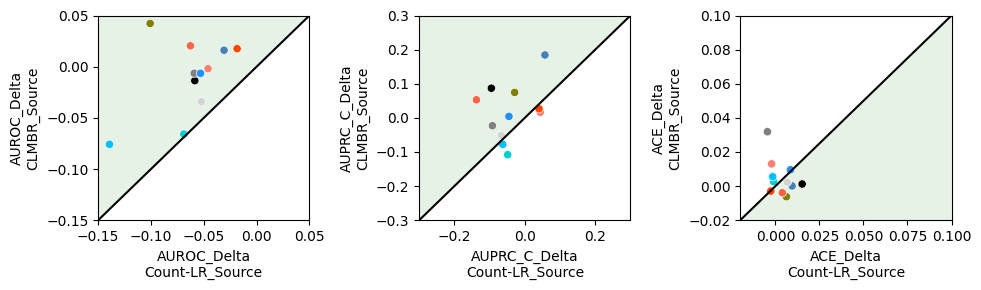

In [8]:
fig,axes=plt.subplots(1,3,figsize=(10,3))

for c,metric in enumerate(metrics):
    
    df_clmbr_source_ood = (
        df.query("metric==@metric and model=='CLMBR_Source' and test_adapter=='ped'")
        [['performance','task']]
        .sort_values('task')
        .reset_index(drop=True)
    )
    
    df_count_source_ood = (
        df.query("metric==@metric and model=='LR' and test_cohort=='pediatric' and train_cohort=='adult'")
        [['performance','task']]
        .sort_values('task')
        .reset_index(drop=True)
    )   
    
    df_clmbr_source_id = (
        df.query("metric==@metric and model=='CLMBR_Target' and test_adapter=='ped'")
        [['performance','task']]
        .sort_values('task')
        .reset_index(drop=True)
    )
    
    df_count_source_id = (
        df.query("metric==@metric and model=='LR' and test_cohort=='pediatric' and train_cohort=='pediatric'")
        [['performance','task']]
        .sort_values('task')
        .reset_index(drop=True)
    )
    
    df_clmbr = df_clmbr_source_ood.assign(diff = df_clmbr_source_ood['performance']-df_clmbr_source_id['performance'])
    df_count = df_count_source_ood.assign(diff = df_count_source_ood['performance']-df_count_source_id['performance'])
    
    df_clmbr = df_clmbr.query("task==@tasks")
    df_count = df_count.query("task==@tasks")
    
    tasks = df_count.task.tolist()
    colours = [task_colours[x] for x in tasks]
    
    axes[c].plot(metrics[metric]['lim'],metrics[metric]['lim'],'k-')
        
    x1 = [metrics[metric]['lim'][0],metrics[metric]['lim'][0],metrics[metric]['lim'][1],metrics[metric]['lim'][0]]
    x2 = [metrics[metric]['lim'][0], metrics[metric]['lim'][1], metrics[metric]['lim'][1], metrics[metric]['lim'][0]]
    y1 = [metrics[metric]['lim'][0],metrics[metric]['lim'][1],metrics[metric]['lim'][1],metrics[metric]['lim'][0]]
    y2 = [metrics[metric]['lim'][0], metrics[metric]['lim'][1], metrics[metric]['lim'][0],metrics[metric]['lim'][0]]
    
    axes[c].fill_between(
        x1 if metric!= 'ace_abs_logistic_logit' else x2,
        y1 if metric!= 'ace_abs_logistic_logit' else y2,
        facecolor='green',
        #hatch='\\\\\\',
        #edgecolor='green',
        alpha=0.1,
    )
    sns.scatterplot(
        x=df_count['diff'],
        y=df_clmbr['diff'],
        ax=axes[c],
        c=colours
    )
    
    axes[c].set_xlim(metrics[metric]['lim'])
    axes[c].set_ylim(metrics[metric]['lim'])
    axes[c].set_xlabel(f"{metrics[metric]['label']}_Delta\nCount-LR_Source")
    axes[c].set_ylabel(f"{metrics[metric]['label']}_Delta\nCLMBR_Source")
    
plt.tight_layout()
plt.show()